In [1]:
from uproot_io import Events, View
import numpy as np
from numpy import *
import matplotlib
import matplotlib.pyplot as plt
import math
titlesize = 20
labelsize = 14

In [2]:
events = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\CheatedRecoFile_1.root")

In [3]:
testing = np.load("testing_events.npy")
ratioclosetrk = np.load("ratioclose_trk.npy")
ratiocloseshw = np.load("ratioclose_shw.npy")
connecttrk = np.load("connect_trk.npy")
connectshw = np.load("connect_shw.npy")
energytrk = np.load("energy_trk.npy")
energyshw = np.load("energy_shw.npy")
variencetrk = np.load("varience_trk.npy")
varienceshw = np.load("varience_shw.npy")
symmetrytrk = np.load("symmetry_trk.npy")
symmetryshw = np.load("symmetry_shw.npy")

In [4]:
def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def coords(event_number):
    idx = np.where(events.event_number == event_number)[0]
    gradients = []
    intercepts = []
    particleType = []
    ratio = []
    results = []
    allSym = []
    E = []
    
    xmax = -1000
    xmin = 1000
    zmax = -1000
    zmin = 1000
    for i in idx:
        x0 = events.reco_hits_x_w[i]
        z0 = events.reco_hits_w[i]
        if len(x0) > 0:
            if max(x0) >= xmax:
                xmax = max(x0)
            if min(x0) <= xmin:
                xmin = min(x0)
        if len(z0) > 0:
            if max(z0) >= zmax:
                zmax = max(z0)
            if min(z0) <= zmin:
                zmin = min(z0)

    xlen = 0.1*(xmax - xmin)
    zlen = 0.1*(zmax - zmin)
    
    for i in idx:
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        pdg = events.mc_pdg[i]
        purity = events.purity[i]
        complete = events.completeness[i]
        
        adc = events.reco_adcs_w[i]
        vx = events.reco_particle_vtx_x[i]
        vz = events.reco_particle_vtx_w[i]
        
        if len(x) > 10 and pdg != 0 and purity > 0.75 and complete > 0.75:
            #particleType.append(pdg)
            
            best_inliers = []
            best_model = None
            sample_size = 10
            max_iterations = 100

            for _ in range(max_iterations):
                sample_size = min(sample_size, len(x))
                sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
                x_sample = x[sample_indices]
                z_sample = z[sample_indices]

                m, c = fit_line(x_sample, z_sample)
                residuals = calculate_residuals(x, z, m, c)
                inliers = np.where(residuals < (0.15*xlen))[0]

                if len(inliers) > len(best_inliers):
                    best_inliers = inliers
                    best_model = (m, c)

            if len(best_inliers) > 0:
                m, c = best_model
                gradients.append(m)
                intercepts.append(c)
                particleType.append(pdg)
                
                znew = z - c
                angle = -math.atan(m)
                l = x * np.cos(angle) - znew * np.sin(angle)
                t = x * np.sin(angle) + znew * np.cos(angle)

                
                tdiff = np.abs(max(t)-min(t))
                margin = tdiff*0.05
                inside = [x for x in t if x <= margin and x >= -margin]
                ratio.append(len(inside)/len(t))
                
                
                p1 = int(0.7 * len(t))
                X = t[p1:]
                Xvar = np.var(X)
                
                p2 = int(0.3 * len(t))
                Y = t[:p2]
                Yvar = np.var(Y)
                
                if  Yvar > Xvar:
                    resultY = np.sqrt(Yvar)
                    results.append(resultY)           
                else:
                    resultX = np.sqrt(Xvar)
                    results.append(resultX)
                
                
                above = np.sum(t > 0)
                below = np.sum(t < 0)
                
                lmin, lmax = np.min(l), np.max(l)
                length = lmax - lmin

                if above == 0 or below == 0 or length == 0:
                    allSym.append(2)
                    
                else:
                    # If symmetric, this should be close to 1, otherwise > 1
                    sym = (above + below) / length
                    allSym.append(sym)
            
                
                vznew = vz - c
                
                vl = vx * np.cos(angle) - vznew * np.sin(angle)
                vt = vx * np.sin(angle) + vznew * np.cos(angle)
                
                if max(l) < vl:
                    l *= -1
                    
                combined = list(zip(l, t, adc))
                sort = sorted(combined, key = lambda coord: coord[0])
                
                lnew, tnew, adcnew = zip(*sort)
                
                percent = int(0.9 * len(adcnew))
                X = adcnew[percent:]
                Xsum = np.sum(X)

                total = np.sum(adcnew)
                result = Xsum / total

                E.append(result)
            
            else:
                ratio.append(0.1)
                results.append(1.5)
                allSym.append(2)
                E.append(0.25)
                particleType.append(pdg)
    
    return particleType, ratio, results, allSym, E

In [5]:
def connectiondist(event_number):
    totals = []
    parts = []
    
    idx = np.where(events.event_number == event_number)[0]
    newidx = idx - idx[0]
    for i in newidx:
        x = events.reco_hits_x_w[i+idx[0]]
        z = events.reco_hits_w[i+idx[0]]
        part = events.mc_pdg[i+idx[0]]
        purity = events.purity[i+idx[0]]
        complete = events.completeness[i+idx[0]]
        
        if len(x) > 10 and part != 0 and purity > 0.75 and complete > 0.75 and (len(x)-1) != 0:
            total_distance = 0.0
            for j in range(len(x) - 1):
                distance = np.sqrt((x[j+1] - x[j])**2 + (z[j+1] - z[j])**2)
                total_distance += distance
            meandist = total_distance/(len(x)-1)
            totals.append(meandist)
            parts.append(part)
    
    return np.array(totals), np.array(parts)

In [6]:
def energy(event_number):    
    particleType = np.array([])
    E = np.array([])
    
    idx = np.where(events.event_number == event_number)[0]
    for i in idx:
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        adc = events.reco_adcs_w[i]        
        purity = events.purity[i]
        complete = events.completeness[i]
        pdg = events.mc_pdg[i]
        
        if len(x) > 10 and pdg != 0 and purity > 0.75 and complete > 0.75:
            percent = int(0.8 * len(adc))
            X = adc[percent:]
            Xsum = np.sum(X)
            
            total = np.sum(adc)
            result = Xsum / total
            
            if result != 1.0:
                E = np.append(E, result)
                particleType = np.append(particleType, pdg) 
            
    #return E, particleType

In [28]:
def likelihood():
    #trackprob = []
    #showerprob = []
    particle = []
    
    TIT = []
    TIS = []
    SIS = []
    SIT = []
    
    ratiobin = np.arange(0, 1, 0.05)
    totalbin = np.arange(0, 15, 0.5)
    volbin = np.arange(0, 0.5, 0.025)
    resultsbin = np.arange(0, 10, 0.5)
    allSymbin = np.arange(0, 10, 0.5)
    
    #eventno = []
    #particleno = []
    
    for n in testing:
        part, ratio, results, allSym, vol = coords(n)
        total, _ = connectiondist(n)
        #vol, _ = energy(n)
        
        for i in range(len(part)):
            #eventno.append(n)
            #particleno.append(i)
            
            bin1 = np.searchsorted(ratiobin, ratio[i], side='right') - 1
            bin2 = np.searchsorted(totalbin, total[i], side='right') - 1
            bin3 = np.searchsorted(volbin, vol[i], side='right') - 1
            bin4 = np.searchsorted(resultsbin, results[i], side='right') - 1
            bin5 = np.searchsorted(allSymbin, allSym[i], side='right') - 1
            
            trk1 = ratioclosetrk[bin1]
            trk2 = connecttrk[bin2]
            trk3 = energytrk[bin3]
            trk4 = variencetrk[bin4]
            trk5 = symmetrytrk[bin5]
            trackprob = (trk1*trk2*trk3*trk4*trk5)

            shw1 = ratiocloseshw[bin1]
            shw2 = connectshw[bin2]
            shw3 = energyshw[bin3]
            shw4 = varienceshw[bin4]
            shw5 = symmetryshw[bin5]
            showerprob = (shw1*shw2*shw3*shw4*shw5)
            
            TRKlike = trackprob/(trackprob+showerprob)
            SHWlike = showerprob/(trackprob+showerprob)
            particle.append(part)
            
            if part[i] == 22. or part[i] == -11. or part[i] == 11.:
                SIS.append(SHWlike)
                SIT.append(TRKlike)
            else:
                TIS.append(SHWlike)
                TIT.append(TRKlike)
            
    return TIT, TIS, SIS, SIT

In [29]:
TIT, TIS, SIS, SIT = likelihood()

C:\Users\andre\AppData\Local\Temp\ipykernel_11488\2988699642.py:49: RuntimeWarning: invalid value encountered in scalar divide
  TRKlike = trackprob/(trackprob+showerprob)
C:\Users\andre\AppData\Local\Temp\ipykernel_11488\2988699642.py:50: RuntimeWarning: invalid value encountered in scalar divide
  SHWlike = showerprob/(trackprob+showerprob)


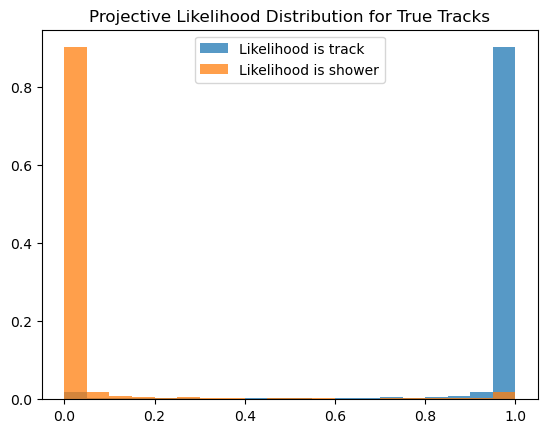

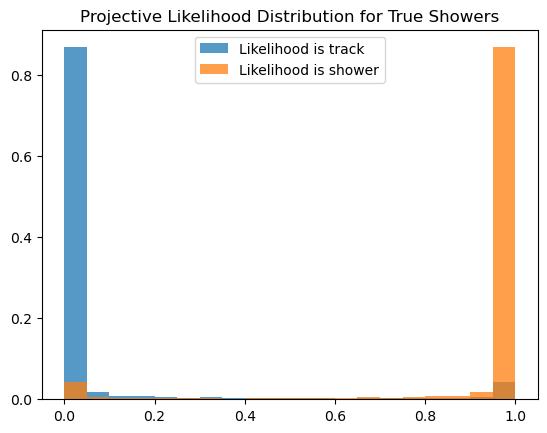

In [30]:
bin_edges = np.arange(0, 1.05, 0.05)
hist1, _ = np.histogram(TIT, bins=bin_edges)
hist2, _ = np.histogram(TIS, bins=bin_edges)
   
hist1_normalized = hist1 / len(TIT)
hist2_normalized = hist2 / len(TIS)

plt.bar(bin_edges[:-1], hist1_normalized, width=0.05, align='edge', alpha=0.75, label='Likelihood is track')
plt.bar(bin_edges[:-1], hist2_normalized, width=0.05, align='edge', alpha=0.75, label='Likelihood is shower')
plt.title('Projective Likelihood Distribution for True Tracks')
plt.legend(loc='upper center')
plt.show()

hist1, _ = np.histogram(SIS, bins=bin_edges)
hist2, _ = np.histogram(SIT, bins=bin_edges)
   
hist1_normalized = hist1 / len(SIS)
hist2_normalized = hist2 / len(SIT)

plt.bar(bin_edges[:-1], hist2_normalized, width=0.05, align='edge', alpha=0.75, label='Likelihood is track')
plt.bar(bin_edges[:-1], hist1_normalized, width=0.05, align='edge', alpha=0.75, label='Likelihood is shower')
plt.title('Projective Likelihood Distribution for True Showers')
plt.legend(loc='upper center')
plt.show()

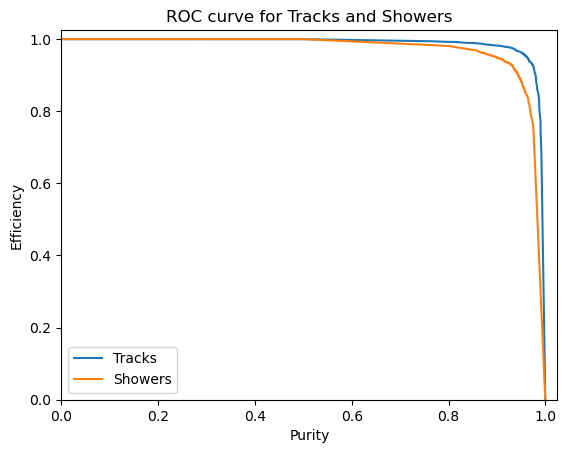

Track best cut: 0.491
At distance: 0.06076018501102528
With AUC: 0.9873713657655634

Shower best cut: 0.494
At distance: 0.09914372469658983
With AUC: 0.9707125639413302


In [68]:
cuts = np.arange(0, 1, 0.001)
tefficiency = []
tpurity = []
sefficiency = []
spurity = []

tpurity.append(0)
tefficiency.append(1)
spurity.append(0)
sefficiency.append(1)

for i in cuts:
    big1t = []
    small1t = []
    big2t = []
    small2t = []
    for n in TIT:
        if n >= i:
            big1t.append(n)
        else:
            small1t.append(n)
    for k in TIS:
        if k >= i:
            big2t.append(k)
        else:
            small2t.append(k)

    eff = len(big1t)/(len(TIT))
    pur = len(big1t)/(len(big1t)+len(big2t))

    tefficiency.append(eff)
    tpurity.append(pur)

for i in cuts:
    big1s = []
    small1s = []
    big2s = []
    small2s = []
    for n in SIS:
        if n >= i:
            big1s.append(n)
        else:
            small1s.append(n)
    for k in SIT:
        if k >= i:
            big2s.append(k)
        else:
            small2s.append(k)

    eff = len(big1s)/(len(SIS))
    pur = len(big1s)/(len(big1s)+len(big2s))

    sefficiency.append(eff)
    spurity.append(pur)

tpurity.append(1)
tefficiency.append(0)
spurity.append(1)
sefficiency.append(0)

plt.plot(tpurity, tefficiency, label='Tracks')
plt.plot(spurity, sefficiency, label='Showers')
plt.xlim(0,1.025)
plt.ylim(0,1.025)
plt.xlabel('Purity')
plt.ylabel('Efficiency')
plt.title('ROC curve for Tracks and Showers')
plt.legend()
plt.show()

tarea = np.trapz(tefficiency, x=tpurity)
sarea = np.trapz(sefficiency, x=spurity)

point = np.array([1, 1])
data_points = np.column_stack((tpurity, tefficiency))
distances = np.linalg.norm(data_points - point, axis=1)
closest_index = np.argmin(distances)
closest_point = data_points[closest_index]
dist = distances[closest_index]

print('Track best cut:', cuts[closest_index])
print('At distance:', dist)
print('With AUC:', tarea)

data_points = np.column_stack((spurity, sefficiency))
distances = np.linalg.norm(data_points - point, axis=1)
closest_index = np.argmin(distances)
closest_point = data_points[closest_index]
dist = distances[closest_index]

print('')
print('Shower best cut:', cuts[closest_index])
print('At distance:', dist)
print('With AUC:', sarea)

#efficiency (true tracks as tracks/total true tracks)
#purity (true tracks as tracks/number we have called tracks)